In [9]:
## Receive the signal
include("../data/julia/rxsignal_withchannelandfreqoff.jl");

In [10]:
## Load the template signal
include("../data/julia/pss2.jl");

In [11]:
using FFTW
using DSP

In [12]:
## Load the useful math operations
include("../modules/operations.jl");

In [13]:
## Assign the received signal a variable Ŝᵣₓ³
𝑅ₚₛₛ³ = rxs3; # RX Received Signal 3 File Handle
@show size(𝑅ₚₛₛ³), typeof(𝑅ₚₛₛ³);

(size(𝑅ₚₛₛ³), typeof(𝑅ₚₛₛ³)) = ((616447, 1), Matrix{ComplexF64})


In [14]:
using LinearAlgebra

In [15]:
## Assign the template signal a variable 𝐻ₚₛₛ²
## convert the signal in time domain
Pₚₛₛ² = pss_2; # File Handle
# Hₚₛₛ²ᵀ = transpose(Pₚₛₛ²); # Hessian Transpose ?
𝐻ₚₛₛ² = Fᴵ(Pₚₛₛ²); # S Slanted (fourier transform) in time domain
𝐻ₚₛₛ² ./= norm(𝐻ₚₛₛ²);
𝐻ₚₛₛ² = 𝐻ₚₛₛ²[(end-143):end] ⧺ 𝐻ₚₛₛ²
@show size(𝐻ₚₛₛ²), typeof(𝐻ₚₛₛ²); # end is 2048 in this case, concat math 

(size(𝐻ₚₛₛ²), typeof(𝐻ₚₛₛ²)) = ((2192,), Vector{ComplexF64})


In [16]:
## Prepare the template signal for convolution
𝐻̅ₚₛₛ² = ⦰(𝐻ₚₛₛ²); # reverse #typed H\overbar
𝐻̅ₚₛₛ²ᴴ = conj(𝐻̅ₚₛₛ²); # conjugate 
@show length(𝐻̅ₚₛₛ²ᴴ), typeof(𝐻ₚₛₛ²);

(length(𝐻̅ₚₛₛ²ᴴ), typeof(𝐻ₚₛₛ²)) = (2192, Vector{ComplexF64})


In [17]:
## Perform the convolution between the 2 signals
𝐻̂ₚₛₛ² = 10 * log10.(abs.( 𝑅ₚₛₛ³ ⊗ 𝐻̅ₚₛₛ²ᴴ ))
@show size( 𝐻̂ₚₛₛ² ), typeof(𝐻̂ₚₛₛ²);  #typed \itH\hat

(size(𝐻̂ₚₛₛ²), typeof(𝐻̂ₚₛₛ²)) = ((618638, 1), Matrix{Float64})


In [18]:
# Find maximum value and its index
Ĉᵩ², 𝑁̂𝑓² = argmax(𝐻̂ₚₛₛ²)
@show Ĉᵩ², 𝑁̂𝑓²;

(Ĉᵩ², 𝑁̂𝑓²) = (50.649042476081405, CartesianIndex(6628, 1))


In [19]:
using Plots

In [20]:
# Plot the result
m2_chan_plot = 
plot(𝐻̂ₚₛₛ², xlabel="Sample", ylabel="Power (dB)", title="Convolution Result", ylim=(-20, 60))
savefig(m2_chan_plot,"images/m2_chan_plot.png");

<img src=images/m2_chan_plot.png width='' heigth='' > </img>

In [21]:
########################################################
# Frequency Offset Estimator Function
########################################################
function freq_offset_est(𝑅ₚₛₛ, 𝐻ₚₛₛ, Nf, m, 𝑓ₛ)

    # Frequency offset estimator
    Y = zeros(ComplexF64, length(m));
    L = length(𝐻ₚₛₛ)
    t = 0:(1/𝑓ₛ):((L-1)/𝑓ₛ)

    signal_part = 𝑅ₚₛₛ[Nf:(Nf + L -1)]; @show size( signal_part )
    for j = 1:length(m)
        Y[j] = Y[j] + abs.(∑(exp.(-2*pi*im*m[j].*t) .* conj(𝐻ₚₛₛ) .* ⦰(signal_part)))^2;
    end

    return Y
end

freq_offset_est (generic function with 1 method)

In [22]:
𝑓ₛ = 61.44e6 # Msamples/s.

Δ𝑓 = 10.0
m = -7500.:Δ𝑓:7500.

θ₁ = 144 # Cyclic Prefix
θ₂ = 2048 # FFT Size

2048

In [25]:
N𝑓 = getindex(𝑁̂𝑓², 1) - length(𝐻ₚₛₛ²) + 1
@show N𝑓, getindex(𝑁̂𝑓², 1) , length(𝐻ₚₛₛ²);

(N𝑓, getindex(𝑁̂𝑓², 1), length(𝐻ₚₛₛ²)) = (4437, 6628, 2192)


In [26]:
# Grab the function Profs Frequency Offset with his values
Y = freq_offset_est(𝑅ₚₛₛ³, 𝐻ₚₛₛ², N𝑓, m, 𝑓ₛ)
@show size(Y), typeof(Y);

size(signal_part) = (2192,)
(size(Y), typeof(Y)) = ((1501,), Vector{ComplexF64})


In [27]:
N̂𝑓, m̂ = argmax(abs.(Y))
@show m̂, 10 * log10(N̂𝑓);

(m̂, 10 * log10(N̂𝑓)) = (587, 88.46888484427753)


In [61]:
cfo_estim_plot = 
plot(10 * log10.(abs.(Y))
    , xlabel="Sample"
    , ylabel="Power (dB)"
    , title="Estimation Result"
);
# scatter!((m̂, (10 * log10(N̂𝑓))), color="red", label="m̂")
# savefig(cfo_estim_plot,"images/cfo_estim_plot.png");

<img src="images/cfo_estim_plot.png" width='' height='' > </img>

In [62]:
# Compensate CFO by multiplying the received signal with a complex exponential
function compensate_cfo(𝑅ₚₛₛ, N̂𝑓, 𝑓ₛ, Npss)
    # Generate a complex exponential with the specified frequency offset
    # 𝑅ₚₛₛ = 𝑅ₚₛₛ .* exp.(-2π * im * collect(1:4*Npss) * (N̂𝑓/𝑓ₛ))
    𝑅ₚₛₛ = 𝑅ₚₛₛ .* exp.(-2π * im * collect(1:4*Npss) * (N̂𝑓/𝑓ₛ))
    return 𝑅ₚₛₛ
end

compensate_cfo (generic function with 1 method)

In [63]:
headₛₛᵦ = N𝑓+θ₁; tailₛₛᵦ = headₛₛᵦ + (4 * (θ₁+θ₂)); @show headₛₛᵦ, tailₛₛᵦ;

(headₛₛᵦ, tailₛₛᵦ) = (4581, 13349)


In [64]:
𝑅̅ₚₛₛ = 𝑅ₚₛₛ³[headₛₛᵦ:tailₛₛᵦ-1]; @show size(𝑅̅ₚₛₛ);

size(𝑅̅ₚₛₛ) = (8768,)


In [65]:
# Tu = 2048 # Unit of samples
Tu = (θ₁+θ₂)

2192

In [66]:
Y = compensate_cfo(𝑅̅ₚₛₛ, N̂𝑓, 𝑓ₛ, Tu);

## PSS demodulation

In [67]:
using FFTW, DSP

In [68]:
# Start demodulation 
𝐹ₓ = DSP.fftshift(DSP.fft(Y)); @show size(𝐹ₓ), 𝐹ₓ[1];
# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
# 𝐹ₓ .*= exp.(1im * 2π .* DSP.fftshift(DSP.fftfreq(Tu)) * Ncp / 2); 

(size(𝐹ₓ), 𝐹ₓ[1]) = ((8768,), 37804.69370138299 + 91491.57148331574im)


In [69]:
# The PSS ocuppies subcarriers 56 to 128 relative to the start of an SS/PBCH block
# In this case, the SS/PBCH block starts at subcarrier -120 (with respect to the
# subcarrier we have decided to treat as DC). This means that the SS/PBCH block is
# not centred with respect to this choice of DC (but this doesn't matter).
pss_sc_sel = range(1, 127)

1:127

In [70]:
x_all_sc = collect(0:size(𝐹ₓ,1)); y_all_sc = 10 * log10.(abs2.(𝐹ₓ));

In [71]:
x_pss_sc = collect(0:size(𝐹ₓ,1))[pss_sc_sel]; y_pss_sc = 10 * log10.(abs2.(𝐹ₓ[pss_sc_sel]));

In [74]:
all_sb_plot = 
scatter(x_all_sc, y_all_sc
    , label="All subcarriers"
    , markersize=5
)
scatter!(x_pss_sc, y_pss_sc
    , label="PSS subcarriers"
    , markershape=:vline
    , markersize=5
)

title!("PSS subcarrier power")
xlabel!("Subcarrier number (DC = 0)")
ylabel!("Power (dB)")

savefig(all_sb_plot,"images/all_sb_plot.png");

<img src="images/all_sb_plot.png" width='' height='' > </img>

In [75]:
cp_corr = zeros(ComplexF64, round(Int, 𝑓ₛ * 0.4e-3)); @show size(cp_corr);
corr_start = round(Int, 9.05e-3 * 𝑓ₛ); @show corr_start;
for j in 1:length(cp_corr)
    y = 𝐹ₓ[corr_start + j:corr_start + j + N̂𝑓 + Tu - 1]
    cp_corr[j] = sum(y[1:N̂𝑓] .* conj.(y[end-N̂𝑓+1:end]))
end

t_corr = 1e3 * (collect(0:length(cp_corr)-1) .+ corr_start) / 𝑓ₛ; @show t_corr[1];

size(cp_corr) = (24576,)
corr_start = 556032


LoadError: BoundsError: attempt to access 8768-element Vector{ComplexF64} at index [556033.0:1.0:7.03450036e8]

In [76]:
plot(t_corr, real.(cp_corr), label="I")
plot!(t_corr, imag.(cp_corr), label="Q")

xlabel!("Time (ms)")
ylabel!("Amplitude")
title!("Poor man's Schmidl & Cox: cyclic prefix correlation")

LoadError: UndefVarError: `t_corr` not defined

In [77]:
function plot_ref(ref; ax=nothing, refscale=1)
    const_dict = Dict(
    "bpsk" => [-1, 1],
    "pilot" => [1],
    "qpsk" => [exp(1.0im * (π/2 * k + π/4)) for k in 0:3]
    )

    constant = get(const_dict, ref, nothing) * refscale
    ax = ax isa Nothing ? plt : ax
    scatter!(ax, real(constant), imag(constant), color=:red, markersize=3)
end

function constellation_plot(z::Vector{ComplexF64}; title=nothing, ref="bpsk", ax=nothing, refscale=1, kwargs...)
    ax = ax isa Nothing ? plot(size=(300, 300)) : ax
    scatter!(ax, real(z), imag(z), kwargs...)
    plot_ref(ref, ax=ax, refscale=refscale)
    plot!(ax, aspect_ratio=:equal, xlims=(-1.5, 1.5), ylims=(-1.5, 1.5), xticks=[], yticks=[])
    # title && title!(ax, title)
    if title !== nothing
        title!(ax, title)
    end
end

constellation_plot (generic function with 1 method)

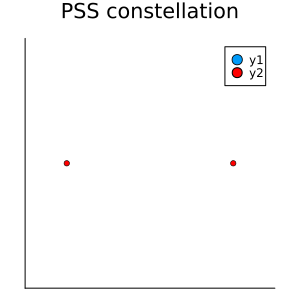

In [78]:
pss_sym_demod = 𝐹ₓ[pss_sc_sel];
constellation_plot(pss_sym_demod, title="PSS constellation")

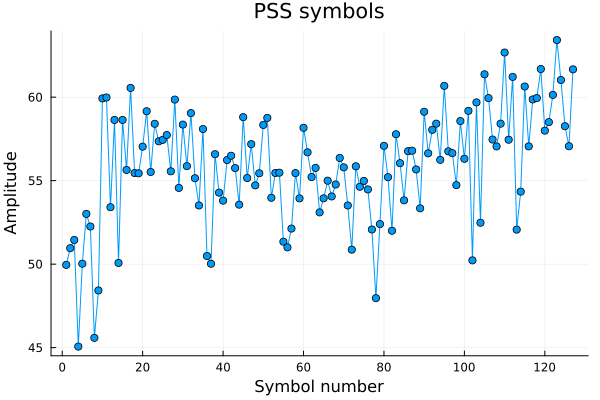

In [41]:
plot(real(10 * log10.(pss_sym_demod)), marker=:circle, label="")
title!("PSS symbols")
xlabel!("Symbol number")
ylabel!("Amplitude")

In [42]:
function pss_sequence(nid2)
    x = zeros(UInt8, 127)
    x[1:7] .= [1, 1, 1, 0, 1, 1, 0][end:-1:1]

    for j in 8:127
        x[j] = x[j - 3] ^ x[j - 6]
    end

    indices = x[(collect(1:127) .+ 43 * nid2) .% 127 .+ 1]
    return 1.0 .- 2.0 .* float.(indices)
end

pss_sequence (generic function with 1 method)

In [43]:
@show size(pss_sym_demod)

size(pss_sym_demod) = (127,)


(127,)

In [44]:
pss_sym_demod_wipe = float(pss_sym_demod) .* pss_sequence(1); @show pss_sym_demod_wipe;

pss_sym_demod_wipe = ComplexF64[-37804.693622661114 - 91491.57148426706im, 22408.619551767326 + 122614.82160993002im, 62645.07148224085 - 124737.59286859131im, -31475.03156696829 - 6153.331352687779im, -18514.803965866406 - 98833.11318660522im, 24494.44710684058 + 198483.97406533343im, 145386.9244976466 - 84281.9260048311im, -20238.033637855362 - 29993.73629787252im, -21891.40644495155 - 66018.954735542im, 195018.36931112662 + 963697.5826241im, -775475.8518642359 - 625030.3884054986im, -214906.24131643813 + 43598.7629180864im, 138964.5973558092 - 717178.5103908313im, -50622.26671565676 + 88191.10563465003im, 608962.6289350395 - 404138.97928086173im, 340872.9884849286 - 134871.9555060759im, 177593.2257547671 + 1.1222572392241398e6im, -325121.49993530964 - 133143.88589424084im, -283628.85291624244 - 204703.56915515693im, 78027.18759286747 + 499118.0623671538im, -148074.8881482249 - 810399.3150149945im, 275966.0157939594 + 225717.8174403326im, 115946.19611897404 + 682954.3375082298im, -27

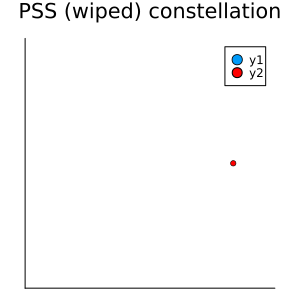

In [45]:

constellation_plot(pss_sym_demod_wipe, title="PSS (wiped) constellation", ref="pilot")